In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from model import ReachabilityModel, GaussianReachabilityModel, GaussianReachabilityModelv2

#### Create Array of Pandas Dataframes for each CSV File in Dataset

In [3]:
dfs = []
datapath = os.getcwd() + '\data'
for item in os.listdir(datapath):
    fullpath = os.path.join(datapath, item)
    if os.path.isfile(fullpath):
        dfs.append(pd.read_csv('data/' + item))

C:\Users\cwphu\AppData\Local\Temp\ipykernel_22344\3426312423.py:6: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv('data/' + item))


#### Clean Each Input/Output DF and Generate Player Name -> Player ID Dictionary

In [4]:
def cleanInputData(df):
    cleandf = df.copy()
    cleandf = cleandf[cleandf['player_to_predict']==True]
    cleandf['unique_play_id'] = cleandf['game_id'].astype(str) + cleandf['play_id'].astype(str) + cleandf['nfl_id'].astype(str)
    cleandf = cleandf.drop(columns=['game_id', 'play_id', 'player_to_predict', 'player_birth_date', 'player_position'])
    cleandf['v_x'] = np.sin(cleandf['dir']*2*np.pi/360.0) * cleandf['s']
    cleandf['v_y'] = np.cos(cleandf['dir']*2*np.pi/360.0) * cleandf['s']
    cleandf['a_x'] = np.sin(cleandf['dir']*2*np.pi/360.0) * cleandf['a']
    cleandf['a_y'] = np.cos(cleandf['dir']*2*np.pi/360.0) * cleandf['a']
    cleandf['o'] = cleandf['o']/360.0
    cleandf = cleandf.drop(columns=['s', 'a', 'dir'])
    return cleandf

def cleanOutputData(df):
    cleandf = df.copy()
    cleandf['unique_play_id'] = cleandf['game_id'].astype(str) + cleandf['play_id'].astype(str) + cleandf['nfl_id'].astype(str)
    cleandf = cleandf.drop(columns=['game_id', 'play_id'])
    return cleandf

In [5]:
clean_input_dfs = []
for i in range(0, 18):
    clean_input_dfs.append(cleanInputData(dfs[i]))
clean_output_dfs = []
for i in range(18, 36):
    clean_output_dfs.append(cleanOutputData(dfs[i]))

In [6]:
clean_input_dfs[0]

,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_side,player_role,x,y,o,num_frames_output,ball_land_x,ball_land_y,unique_play_id,v_x,v_y,a_x,a_y
26,46137,1,right,42,Justin Reid,6-1,204,Defense,Defensive Coverage,51.32,20.69,0.743556,21,63.259998,-0.22,202309070010146137,0.304740,0.056865,0.481685,0.089884
27,46137,2,right,42,Justin Reid,6-1,204,Defense,Defensive Coverage,51.35,20.66,0.746278,21,63.259998,-0.22,202309070010146137,0.317654,-0.169398,0.652956,-0.348207
28,46137,3,right,42,Justin Reid,6-1,204,Defense,Defensive Coverage,51.39,20.63,0.749389,21,63.259998,-0.22,202309070010146137,0.332626,-0.288028,0.574535,-0.497503
29,46137,4,right,42,Justin Reid,6-1,204,Defense,Defensive Coverage,51.43,20.61,0.749389,21,63.259998,-0.22,202309070010146137,0.342360,-0.336436,0.442215,-0.434564
30,46137,5,right,42,Justin Reid,6-1,204,Defense,Defensive Coverage,51.48,20.58,0.747389,21,63.259998,-0.22,202309070010146137,0.414933,-0.345587,0.338094,-0.281589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285709,42489,29,left,87,Stefon Diggs,6-0,191,Offense,Targeted Receiver,74.34,14.72,0.936528,11,73.870003,11.48,2023091100398742489,-3.941286,1.768804,-5.391898,2.419822
285710,42489,30,left,87,Stefon Diggs,6-0,191,Offense,Targeted Receiver,74.00,14.88,0.013583,11,73.870003,11.48,2023091100398742489,-3.066950,1.623181,-5.895261,3.120063
285711,42489,31,left,87,Stefon Diggs,6-0,191,Offense,Targeted Receiver,73.74,15.03,0.105167,11,73.870003,11.48,2023091100398742489,-2.303738,1.464818,-5.780441,3.675459
285712,42489,32,left,87,Stefon Diggs,6-0,191,Offense,Targeted Receiver,73.56,15.16,0.144278,11,73.870003,11.48,2023091100398742489,-1.516783,1.209532,-5.355652,4.270772


In [7]:
player_dict = dict()
max_play_len = 0
for clean_dfs in clean_input_dfs:
    for _,row in clean_dfs.iterrows():
        id = row['nfl_id']
        max_play_len = max(max_play_len, row['frame_id'])
        if id not in player_dict:
            name = row['player_name']
            player_dict[name] = id

In [8]:
play_keys = dict()
play_counts = dict()
for i in range(0, 18):
    for _,row in clean_input_dfs[i].iterrows():
        name = row['player_name']
        id = row['unique_play_id']
        if name not in play_keys:
            play_keys[name] = {id}
            play_counts[name] = 1
        elif id not in play_keys[name]:
            play_keys[name].add(id)
            play_counts[name] += 1

In [9]:
# only keep players with > 100 plays for finetuned model
filtered_play_counts = dict()
for key in play_counts.keys():
    if play_counts[key] > 100:
        filtered_play_counts[key] = play_counts[key]

In [10]:
player_dict

{'Justin Reid': 46137,
 "L'Jarius Sneed": 52546,
 'Josh Reynolds': 44930,
 'Alex Anzalone': 44888,
 'Brian Branch': 55910,
 'Jerry Jacobs': 53953,
 'Malcolm Rodriguez': 54653,
 'Jerick McKinnon': 41325,
 'Noah Gray': 53591,
 'Mike Edwards': 47882,
 'Marvin Jones': 38696,
 'Nick Bolton': 53487,
 'Amon-Ra St. Brown': 53541,
 'Bryan Cook': 54527,
 'Willie Gay Jr.': 52471,
 'Leo Chenal': 54568,
 'C.J. Gardner-Johnson': 47888,
 'Cameron Sutton': 44906,
 'Kerby Joseph': 54562,
 'Justin Watson': 46213,
 'Jack Campbell': 55882,
 'Marquez Valdes-Scantling': 46243,
 'Rashee Rice': 55920,
 'Brock Wright': 53959,
 'Trent McDuffie': 54486,
 'Michael Danna': 52585,
 'Sam LaPorta': 55899,
 'Jahmyr Gibbs': 55876,
 'Joshua Paschal': 54511,
 'Drue Tranquill': 47913,
 'Richie James': 46309,
 'Blake Bell': 42460,
 'Felix Anudike-Uzomah': 55895,
 'Joshua Williams': 54600,
 'Kadarius Toney': 53449,
 'Isiah Pacheco': 54716,
 'Skyy Moore': 54519,
 'Kalif Raymond': 43584,
 'Charles Harris': 44834,
 'Clyde Edwa

In [11]:
filtered_play_counts

{'Justin Reid': 116,
 "L'Jarius Sneed": 125,
 'Alex Anzalone': 143,
 'Brian Branch': 134,
 'Jerry Jacobs': 116,
 'Amon-Ra St. Brown': 139,
 'Cameron Sutton': 165,
 'Kerby Joseph': 122,
 'Trent McDuffie': 125,
 'Sam LaPorta': 115,
 'A.J. Terrell': 142,
 'Jessie Bates': 127,
 'Kaden Elliss': 107,
 'Adam Thielen': 123,
 'Donte Jackson': 101,
 'Jalen Pitre': 102,
 'Steven Nelson': 115,
 'Kyle Hamilton': 123,
 'Brandon Stephens': 172,
 'Geno Stone': 119,
 'Roquan Smith': 158,
 'Patrick Queen': 148,
 'Martin Emerson': 105,
 "Ja'Marr Chase": 107,
 'Daxton Hill': 133,
 'Cam Taylor-Britt': 104,
 'Logan Wilson': 142,
 'Amari Cooper': 112,
 'DJ Turner II': 114,
 'Mike Hilton': 115,
 'Germaine Pratt': 121,
 'Devin Lloyd': 140,
 'Rayshawn Jenkins': 140,
 'Zaire Franklin': 147,
 'Julian Blackmon': 124,
 'Evan Engram': 115,
 'Calvin Ridley': 113,
 'E.J. Speed': 104,
 'Kenny Moore II': 140,
 'Darious Williams': 143,
 'Foye Oluokun': 139,
 'Michael Pittman': 121,
 'Antoine Winfield Jr.': 132,
 'Carlton

In [12]:
max_play_len

123

#### Generate Input/Output Dataset for Single Player

In [175]:
player_id = player_dict['Kaden Elliss']
single_input = dict()
single_output = dict()
single_labels = dict()

for clean_dfs in clean_input_dfs:
    for _,row in clean_dfs.iterrows():
        if row['nfl_id'] == player_id:
            id = row['unique_play_id']
            data = np.array([row['x'], row['y'], row['o'], row['v_x'], row['v_y'], row['a_x'], row['a_y']])
            if id not in single_input:
                single_input[id] = [data]
                single_output[id] = np.array([row['num_frames_output'], row['ball_land_x'], row['ball_land_y']])
                single_labels[id] = np.array([False])
            else:
                single_input[id].append(data)

for clean_dfs in clean_output_dfs:
    for _,row in clean_dfs.iterrows():
        if row['nfl_id'] == player_id:
            id = row['unique_play_id']
            data = np.array([row['frame_id'], row['x'], row['y']])
            if id not in single_output:
                print("Dataset Error, no corresponding play ID in input dataframe")
            else:
                single_output[id] = np.vstack((single_output[id], data))
                single_labels[id] = np.append(single_labels[id], True)
                land_info = single_output[id][0]
                landx = land_info[1]
                landy = land_info[2]
                if ((abs(landx-row['x'])<1) and (abs(landy-row['y'])<1)):
                    single_labels[id][0] = True

In [176]:
len(single_input.keys())

107

#### Generate Torch Training Tensors

In [177]:
input_sequences = []
input_lens = []
input_destinations = []
output_sequences = []
output_label = []

oversample_ratio = 1

for key in single_input.keys():
    input_seq = single_input[key]
    output_seq = single_output[key]
    labels = single_labels[key]

    for i in range(oversample_ratio):
        input_sequences.append(input_seq)
        input_lens.append(len(input_seq))
        input_destinations.append(output_seq[0])
        output_sequences.append(output_seq[1:])
        output_label.append(labels[0])

    rand_timestamps = np.random.randint(1, len(output_seq), len(output_seq)//4)
    for timestamp in rand_timestamps:
        input_sequences.append(input_seq)
        input_lens.append(len(input_seq))
        input_destinations.append(output_seq[timestamp])
        output_sequences.append(output_seq[1:])
        output_label.append(labels[timestamp])


In [178]:
def normalize_dest(dest,seq):
    new_dest = []
    for i in range(0, len(dest)):
        endx = seq[i][-1][0]
        endy = seq[i][-1][1]
        dx = dest[i][1] - endx
        dy = dest[i][2] - endy
        new_dest.append(np.array([dest[i][0], dx, dy]))
    return new_dest

def normalize_seq(seq):
    new_seq = []
    for i in range(len(seq)):
        temp = []
        for j in range(len(seq[i])-1, 0, -1):
            dx = seq[i][j][0] - seq[i][j-1][0]
            dy = seq[i][j][1] - seq[i][j-1][1]
            norm_arr = np.concatenate((np.array([dx, dy]), seq[i][j][2:]))
            temp.append(norm_arr)
        norm_arr = np.concatenate((np.array([0, 0]), seq[i][0][2:]))
        temp.append(norm_arr)
        temp = temp[::-1]
        temp_stack = np.stack(temp)
        new_seq.append(torch.from_numpy(temp_stack))
    return new_seq

In [179]:
input_destinations_norm = normalize_dest(input_destinations, input_sequences)
input_sequences_norm = normalize_seq(input_sequences)

In [180]:
output_frequency = {}

for item in output_label:
    if item in output_frequency:
        output_frequency[item] += 1
    else:
        output_frequency[item] = 1

for value, count in output_frequency.items():
    print(f"Value: {value}, Frequency: {count}")

Value: False, Frequency: 103
Value: True, Frequency: 274


In [181]:
input_seq_tensor = pad_sequence(input_sequences_norm, batch_first=True)
input_seq_tensor = input_seq_tensor.to(torch.float32)
print(input_seq_tensor.shape)
input_lens_tensor = torch.tensor(input_lens)
input_lens_tensor = input_lens_tensor.to(torch.float32)
print(input_lens_tensor.shape)
input_target_tensor = torch.from_numpy(np.array(input_destinations_norm))
input_target_tensor = input_target_tensor.to(torch.float32)
print(input_target_tensor.shape)
output_tensor = torch.tensor(output_label)
output_tensor = torch.unsqueeze(output_tensor, 1)
output_tensor = output_tensor.to(torch.float32)
print(output_tensor.shape)
print(len(output_sequences))

torch.Size([377, 55, 7])
torch.Size([377])
torch.Size([377, 3])
torch.Size([377, 1])
377


#### Training Loop

In [182]:
batch_size = 32
num_epochs = 100
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [183]:
dataset = list(zip(input_seq_tensor, input_lens_tensor, input_target_tensor, output_tensor))

# --- Train/Validation Split ---
n_total = len(dataset)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_test = n_total - n_train - n_val

train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [184]:
model = GaussianReachabilityModelv2(
    motion_input_dim=7, lstm_layers=3, lstm_hidden_dim=32, fc_hidden_dim=32
).to(device)
PATH = "D:\CWP_DATA\Documents\databowl_2025\model_params\\full_model.pth"
state_dict = torch.load(PATH)
model.load_state_dict(state_dict)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_acc = []
val_acc = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    total, correct = 0, 0
    for seq_tensor, len_tensor, target_tensor, batch_output in train_loader:
        seq_tensor = seq_tensor.to(device)
        len_tensor = len_tensor.to(device)
        target_tensor = target_tensor.to(device)
        batch_output = batch_output.to(device)

        # Forward pass
        y_pred = model(seq_tensor, len_tensor, target_tensor)
        loss_reach = criterion(y_pred.squeeze(), batch_output.squeeze())
        loss = loss_reach

        preds = (y_pred > 0.5).float()
        correct += (preds == batch_output).sum().item()
        total += batch_output.numel()

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader.dataset)
    avg_train_acc = correct / total
    train_acc.append(avg_train_acc)


    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Train Acc: {avg_train_acc:.4f} | ")

Epoch [1/100] Train Loss: 0.0007 | Train Acc: 0.9867 | 
Epoch [2/100] Train Loss: 0.0004 | Train Acc: 0.9920 | 
Epoch [3/100] Train Loss: 0.0003 | Train Acc: 0.9947 | 
Epoch [4/100] Train Loss: 0.0003 | Train Acc: 0.9947 | 
Epoch [5/100] Train Loss: 0.0003 | Train Acc: 0.9920 | 
Epoch [6/100] Train Loss: 0.0003 | Train Acc: 0.9894 | 
Epoch [7/100] Train Loss: 0.0003 | Train Acc: 0.9920 | 
Epoch [8/100] Train Loss: 0.0002 | Train Acc: 0.9947 | 
Epoch [9/100] Train Loss: 0.0002 | Train Acc: 0.9947 | 
Epoch [10/100] Train Loss: 0.0002 | Train Acc: 0.9947 | 
Epoch [11/100] Train Loss: 0.0002 | Train Acc: 0.9947 | 
Epoch [12/100] Train Loss: 0.0002 | Train Acc: 0.9947 | 
Epoch [13/100] Train Loss: 0.0001 | Train Acc: 1.0000 | 
Epoch [14/100] Train Loss: 0.0001 | Train Acc: 0.9973 | 
Epoch [15/100] Train Loss: 0.0001 | Train Acc: 0.9973 | 
Epoch [16/100] Train Loss: 0.0001 | Train Acc: 0.9973 | 
Epoch [17/100] Train Loss: 0.0001 | Train Acc: 0.9973 | 
Epoch [18/100] Train Loss: 0.0001 | Trai

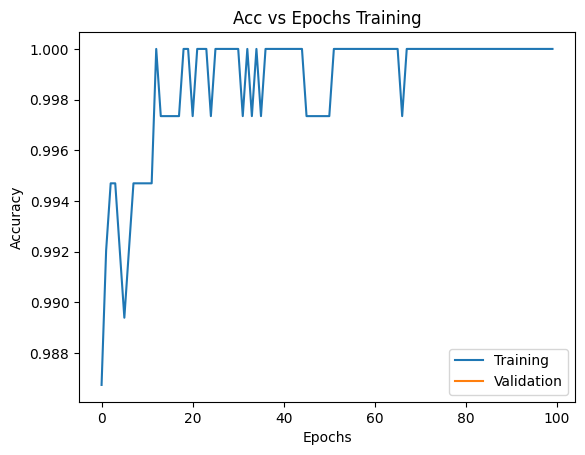

In [185]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Acc vs Epochs Training')
plt.show()

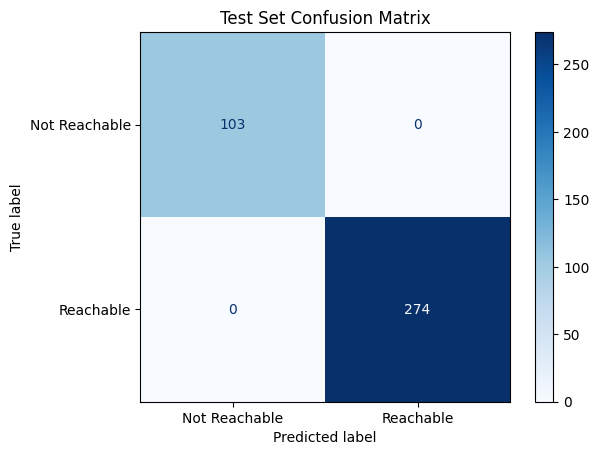

In [186]:
model.eval()
total, correct = 0, 0
all_preds, all_labels = [], []
with torch.no_grad():
    for seq_tensor, len_tensor, target_tensor, batch_output in train_loader:
        seq_tensor = seq_tensor.to(device)
        len_tensor = len_tensor.to(device)
        target_tensor = target_tensor.to(device)
        batch_output = batch_output.to(device)

        y_pred = model(seq_tensor, len_tensor, target_tensor)
        preds = (y_pred > 0.5).float()
        correct += (preds == batch_output).sum().item()
        total += batch_output.numel()

        all_preds.append(preds.cpu())
        all_labels.append(batch_output.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Reachable", "Reachable"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Test Set Confusion Matrix")
plt.show()

In [187]:
## Save off model params
PATH = "D:\CWP_DATA\Documents\databowl_2025\model_params\ceedee_model.pth"
torch.save(model.state_dict(), PATH)

#### Probabilistic Gaussian Modeling

In [204]:
id = 51

eg_input_norm = input_seq_tensor[id]
eg_len = input_lens_tensor[id]
eg_target_norm = input_target_tensor[id]
eg_output = output_tensor[id]
eg_outseq = output_sequences[id]
eg_input = input_sequences[id]
eg_target = input_destinations[id]

In [205]:
landx = eg_target[1].item()
landy = eg_target[2].item()
marker = 'x' if eg_output == 0 else 'o'
print(eg_target)
print(eg_output)
print(marker)

trajectx_before = []
trajecty_before = []
trajectx_after = []
trajecty_after = []
for i in range(0, int(eg_len)):
    trajectx_before.append(eg_input[i][0])
    trajecty_before.append(eg_input[i][1])
for point in eg_outseq:
    trajectx_after.append(point[1])
    trajecty_after.append(point[2])

centerx = int(eg_input[int(eg_len-1)][0].item())
centery = int(eg_input[int(eg_len-1)][1].item())
print(eg_input[int(eg_len-1)])

[ 8.         70.29000092 28.13999939]
tensor([0.])
x
[72.62       19.96        0.65011111  2.39410668 -3.70355953  1.47663723
 -2.28428161]


In [206]:
targets = []
coords_x = []
coords_y = []
for i in range(0, 121):
    for j in range(0, 54):
        dx = i - centerx
        dy = j - centery
        targets.append([eg_target[0].item(), dx, dy])
        coords_x.append(i)
        coords_y.append(j)
targets = torch.tensor(targets)
coords_x = np.array(coords_x)
coords_y = np.array(coords_y)

In [207]:
print(targets)

tensor([[  8., -72., -19.],
        [  8., -72., -18.],
        [  8., -72., -17.],
        ...,
        [  8.,  48.,  32.],
        [  8.,  48.,  33.],
        [  8.,  48.,  34.]])


In [208]:
eg_input_list = [eg_input_norm for _ in range(len(targets))]
eg_lens_list = [eg_len for _ in range(len(targets))]
stacked_eg_input = torch.stack(eg_input_list, dim=0)
stacked_eg_lens = torch.stack(eg_lens_list, dim=0)
stacked_eg_input.shape

torch.Size([6534, 55, 7])

In [209]:
probs = []
model.eval()
with torch.no_grad():
    probs = model(stacked_eg_input.to(device), stacked_eg_lens, targets.to(device))
probs = torch.squeeze(probs).cpu().numpy()

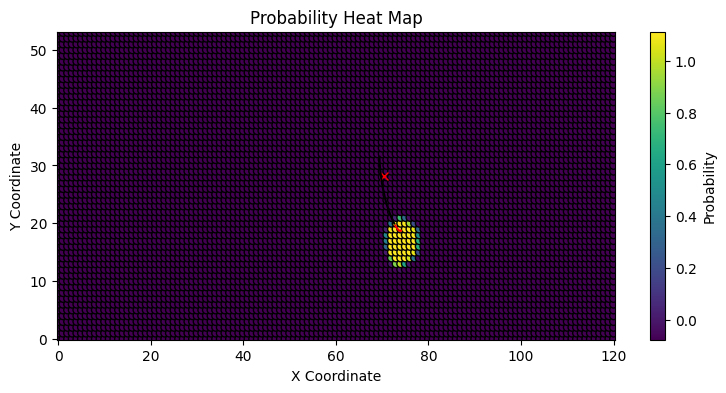

In [210]:
# Create a regular grid to interpolate the data
xi = np.linspace(min(coords_x), max(coords_x), 200)
yi = np.linspace(min(coords_y), max(coords_y), 200)
xi, yi = np.meshgrid(xi, yi)

# Interpolate using griddata (cubic gives smoother results)
zi = griddata((coords_x, coords_y), probs, (xi, yi), method='cubic')

# Plot the heatmap
plt.figure(figsize=(9, 4))
heatmap = plt.pcolormesh(xi, yi, zi, cmap='viridis', shading='auto')
plt.scatter(coords_x, coords_y, c=probs, cmap='viridis', edgecolors='k', s=30)
plt.plot(landx, landy, marker, linestyle='', color='r')
plt.colorbar(heatmap, label='Probability')
plt.plot(trajectx_before, trajecty_before, color='k')
plt.plot(trajectx_after, trajecty_after, color='r')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Probability Heat Map')
plt.show()

In [211]:
print((probs>0.5).sum())

45


In [212]:
base_model = GaussianReachabilityModelv2(
    motion_input_dim=7, lstm_layers=3, lstm_hidden_dim=32, fc_hidden_dim=32
).to(device)
PATH = "D:\CWP_DATA\Documents\databowl_2025\model_params\\full_model.pth"
state_dict = torch.load(PATH)
base_model.load_state_dict(state_dict)

base_probs = []
base_model.eval()
with torch.no_grad():
    base_probs = base_model(stacked_eg_input.to(device), stacked_eg_lens, targets.to(device))
base_probs = torch.squeeze(base_probs).cpu().numpy()

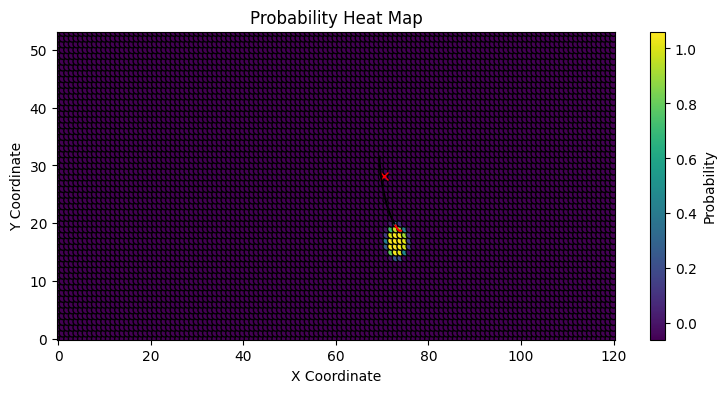

In [213]:
# Create a regular grid to interpolate the data
xi = np.linspace(min(coords_x), max(coords_x), 200)
yi = np.linspace(min(coords_y), max(coords_y), 200)
xi, yi = np.meshgrid(xi, yi)

# Interpolate using griddata (cubic gives smoother results)
zi = griddata((coords_x, coords_y), base_probs, (xi, yi), method='cubic')

# Plot the heatmap
plt.figure(figsize=(9, 4))
heatmap = plt.pcolormesh(xi, yi, zi, cmap='viridis', shading='auto')
plt.scatter(coords_x, coords_y, c=base_probs, cmap='viridis', edgecolors='k', s=30)
plt.plot(landx, landy, marker, linestyle='', color='r')
plt.colorbar(heatmap, label='Probability')
plt.plot(trajectx_before, trajecty_before, color='k')
plt.plot(trajectx_after, trajecty_after, color='r')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Probability Heat Map')
plt.show()

In [214]:
print((base_probs>0.5).sum())

18


In [215]:
print(probs.sum()/base_probs.sum())

2.3130276
